In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Load the dataset
data = pd.read_csv("Company_Data.csv")

# Display the first few rows
print(data.head())


   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


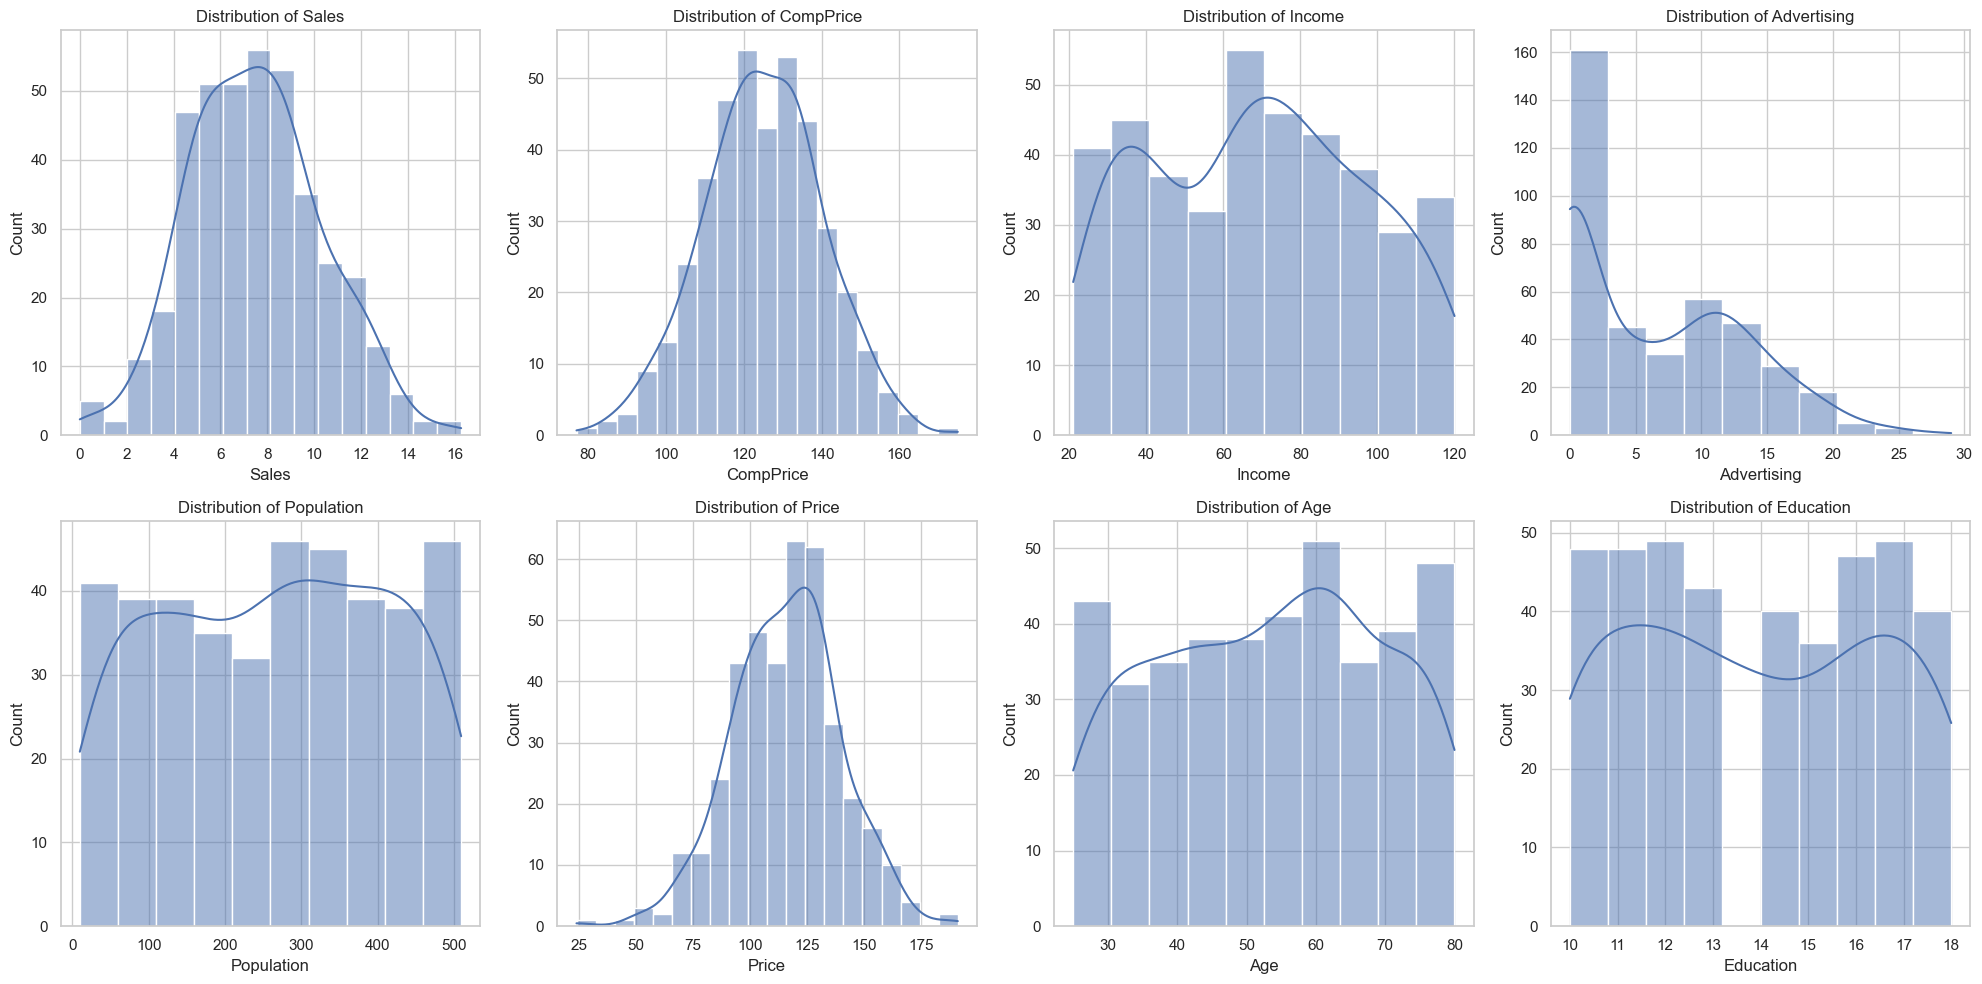

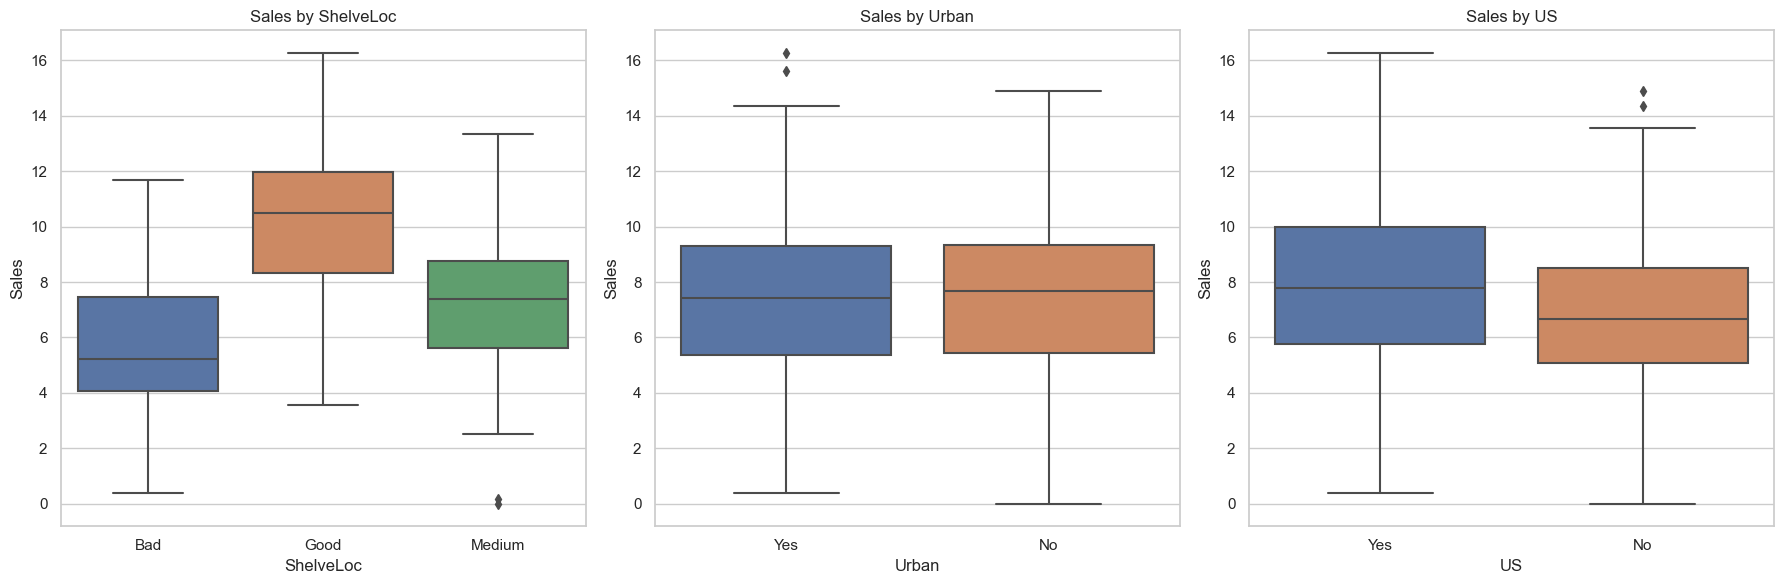

In [17]:
# Set up the visual style
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Plot distribution of 'Sales' and relationship with numerical features
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
numerical_columns = ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], kde=True, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Box plots for Sales by categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
categorical_columns = ['ShelveLoc', 'Urban', 'US']
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Sales', data=data, ax=axes[i])
    axes[i].set_title(f'Sales by {col}')
plt.tight_layout()
plt.show()



In [19]:
# Function to handle outliers by capping at 1.5*IQR
def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply outlier handling to numerical columns
data = handle_outliers(data, numerical_columns)

# Encode categorical variables
data = pd.get_dummies(data, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

# Split dataset into features and target variable
X = data.drop('Sales', axis=1)
y = data['Sales']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Basic Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred))
print("Decision Tree R2 Score:", r2_score(y_test, y_pred))

# Hyperparameter tuning for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Decision Tree Parameters:", best_params)
best_dt_model = grid_search.best_estimator_
y_pred_tuned = best_dt_model.predict(X_test)
print("Tuned Decision Tree MSE:", mean_squared_error(y_test, y_pred_tuned))
print("Tuned Decision Tree R2 Score:", r2_score(y_test, y_pred_tuned))


Decision Tree MSE: 6.1113928125
Decision Tree R2 Score: 0.3693056763796295
Best Decision Tree Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}
Tuned Decision Tree MSE: 4.396678670493395
Tuned Decision Tree R2 Score: 0.5462637789226641


In [22]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))

# Bagging
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42, n_estimators=100)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
print("Bagging MSE:", mean_squared_error(y_test, y_pred_bagging))
print("Bagging R2 Score:", r2_score(y_test, y_pred_bagging))

# Gradient Boosting
boosting_model = GradientBoostingRegressor(random_state=42)
boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
print("Boosting MSE:", mean_squared_error(y_test, y_pred_boosting))
print("Boosting R2 Score:", r2_score(y_test, y_pred_boosting))


Random Forest MSE: 2.9022296030625006
Random Forest R2 Score: 0.7004905767551626
Bagging MSE: 2.984340182875
Bagging R2 Score: 0.6920167839249916
Boosting MSE: 1.9666897355151023
Boosting R2 Score: 0.7970380745327319


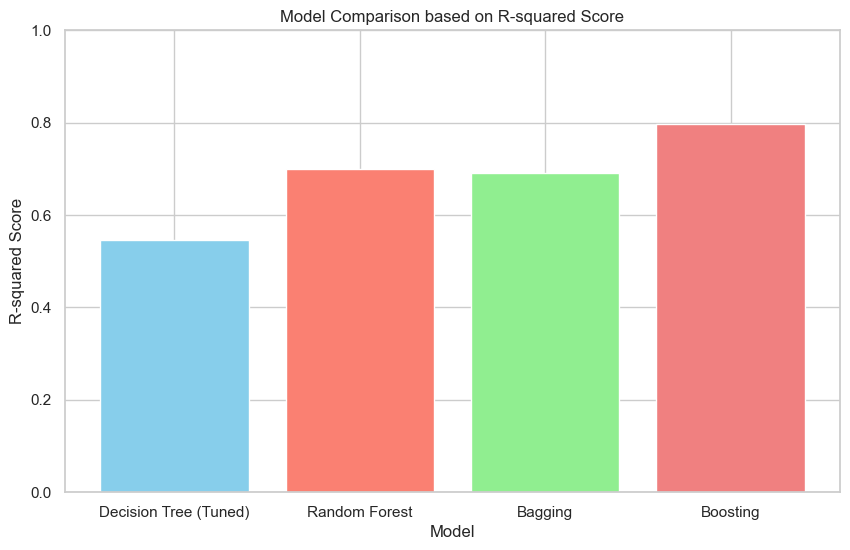

In [25]:
# Collect R-squared scores for comparison
models = ['Decision Tree (Tuned)', 'Random Forest', 'Bagging', 'Boosting']
r2_scores = [
    r2_score(y_test, y_pred_tuned), 
    r2_score(y_test, y_pred_rf), 
    r2_score(y_test, y_pred_bagging), 
    r2_score(y_test, y_pred_boosting)
]

# Plot the R-squared scores
plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
plt.xlabel('Model')
plt.ylabel('R-squared Score')
plt.title('Model Comparison based on R-squared Score')
plt.ylim(0, 1)
plt.show()
